In [ ]:
%reset -f

In [ ]:
import os
import warnings
import pickle as pkl
from joblib import dump, load
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import (KFold, ParameterGrid, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.preprocessing import Imputer, StandardScaler
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
os.chdir("/home/khushi/Desktop/DataScience/Datasets/DataDriven_PumpItUp/")
os.getcwd()

In [ ]:
na_vals = ["", "?", "-", "None", "NA"]
train_vals = pd.read_csv("TrainingSetValues.csv", sep=",", na_values=na_vals)
train_labels = pd.read_csv("TrainingSetLabels.csv", sep=",", na_values=na_vals)

test = pd.read_csv("TestSetValues.csv", sep=",", na_values=na_vals)

In [ ]:
test_id = test['id']

In [ ]:
train_vals.head(3)

In [ ]:
train_labels.head(3)

In [ ]:
test.head(3)

In [ ]:
train_vals.info()

In [ ]:
train_labels.info()

In [ ]:
train = pd.merge(train_vals,train_labels,left_on="id",right_on="id")

In [ ]:
train.info()

In [ ]:
del train_labels
del train_vals

In [ ]:
train.drop('id',axis=1,inplace=True)

In [ ]:
def dropCols(data,cols,inplace_param = True):
    existing_cols = data.columns.intersection(cols)
    return data.drop(existing_cols,axis=1,inplace= inplace_param)

In [ ]:
dropCols(train,['id'])
dropCols(test,['id'])

In [ ]:
train.columns

In [ ]:
cat_var = train.dtypes[train.dtypes == 'object'].index
cat_var = cat_var.union(['district_code','region_code','construction_year'])
print("Categorical variables: %d"%len(cat_var),"\n",cat_var)

In [ ]:
num_var = train.columns.difference(cat_var)
print("Numerical variables:%d"%len(num_var),"\n",num_var)

In [ ]:
train[cat_var] = train[cat_var].apply(lambda x: x.astype('category'))
train.dtypes

In [ ]:
#water_quality can be ordinal
#construction_year, date_recorded datetime type

### Exploratory Data Analysis

In [ ]:
#train_bkp = train.copy(deep=True)
#test_bkp = test.copy(deep=True)

In [ ]:
train.describe(include='category').T.sort_values(by='unique',ascending=False)

In [ ]:
np.unique(train[['extraction_type','extraction_type_group']].values)

In [ ]:
pd.unique(train[['extraction_type','extraction_type_group']].values.ravel())

In [ ]:
train.columns

In [ ]:
train.groupby(["status_group"]).mean()

In [ ]:
train.groupby(["status_group"]).agg(['min','max','mean','count'])

In [ ]:
#same as above. kept just for reference of syntax
#train.groupby(["status_group"])['amount_tsh','gps_height','num_private','population'].agg(['min','max','mean','count'])

In [ ]:
pd.pivot_table(data=train,index='status_group',columns=['source'],values=['amount_tsh'])

#### dams,river,shallowwell,spring which have more water are functional 
#### handdtw,machinedbh,unknown source have more water but most of them need to be repaired
#### lakes have more water but are not functional 

In [ ]:
pd.pivot_table(data=train,index='status_group',columns=['source'],values=['population'],aggfunc=np.sum)

#### dams,machine dbh,rainwater harvesting, river,shallow well,spring which have more population are functional 
#### lake,unknown sources which  have more population are non-functional

### Preprocessing

In [ ]:
rand_num = 3423

In [ ]:
target_var = 'status_group'
y = train[target_var]
X = train.drop(target_var, axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_num)

In [ ]:
del train
del X
del y

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
cols_to_drop = ['longitude','latitude','recorded_by','scheme_name','ward',
                'subvillage','wpt_name','date_recorded','funder','installer',
                'lga','construction_year','region_code','district_code',
               'management','scheme_management','extraction_type',
                'extraction_type_group','region',
               'quantity_group','source_type','source_class','payment_type',
               'quantity_group','waterpoint_type','water_quality']

dropCols(X_train,cols_to_drop)
dropCols(X_test,cols_to_drop)
dropCols(test,cols_to_drop)

In [ ]:
print(X_train.describe().T)
print(X_train.describe(include=['category']).T)

In [ ]:
X_train['source'].dtype

In [ ]:
X_train['source'] = X_train['source'].str.replace('unknown','other')
X_test['source'] = X_test['source'].str.replace('unknown','other')
test['source'] = test['source'].str.replace('unknown','other')
print(X_train.source.unique())


In [ ]:
X_train['management_group'] = X_train['management_group'].str.replace('unknown','other')
X_test['management_group'] = X_test['management_group'].str.replace('unknown','other')
test['management_group'] = test['management_group'].str.replace('unknown','other')
print(X_train.management_group.unique())

In [ ]:
X_train['payment'] = X_train['payment'].str.replace('unknown','other')
X_test['payment'] = X_test['payment'].str.replace('unknown','other')
test['payment'] = test['payment'].str.replace('unknown','other')
print(X_train.payment.unique())

In [ ]:
new_cat_var = X_train.dtypes[X_train.dtypes == 'object'].index
print(new_cat_var)
print(X_train.info())

In [ ]:
X_train[new_cat_var] = X_train[new_cat_var].apply(lambda x: x.astype('category'))
X_test[new_cat_var] = X_test[new_cat_var].apply(lambda x: x.astype('category'))
test[new_cat_var] = test[new_cat_var].apply(lambda x: x.astype('category'))

#### Imputation

In [ ]:
X_train[['public_meeting','permit']].info()

In [ ]:
X_train['public_meeting'].fillna(X_train['public_meeting'].value_counts().index[0],inplace=True)
X_test['public_meeting'].fillna(X_test['public_meeting'].value_counts().index[0],inplace=True)
test['public_meeting'].fillna(test['public_meeting'].value_counts().index[0],inplace=True)

In [ ]:
X_train['permit'].fillna(X_train['permit'].value_counts().index[0],inplace=True)
X_test['permit'].fillna(X_test['permit'].value_counts().index[0],inplace=True)
test['permit'].fillna(test['permit'].value_counts().index[0],inplace=True)
print(X_train.isna().sum())

#### Standardize the numerical variables

In [ ]:
new_num_var = X_train.dtypes[X_train.dtypes != 'category'].index
new_cat_var = X_train.dtypes[X_train.dtypes == 'category'].index

In [ ]:
print(X_train[new_num_var].info())

In [ ]:
scaler = StandardScaler()
X_train[new_num_var] = scaler.fit_transform(X_train[new_num_var])
X_test[new_num_var] = scaler.transform(X_test[new_num_var])
test[new_num_var] = scaler.transform(test[new_num_var])
print(X_train[new_num_var].describe())

#### Dummy code Categorical variables

In [ ]:
#X_train = pd.get_dummies(X_train,drop_first=True,prefix='d',prefix_sep='_')
X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [ ]:
X_train.info()

#### Build Models

In [ ]:
metric = 'accuracy'
models = []
model_names = []
scores = []
train_preds = None
val_preds = None

In [ ]:
#main method to fit a model,do predictions and print metrics
def predictModelMetrics(model,model_name):
    train_preds,val_preds = resetVar()
    train_preds,val_preds = doPredict(model,model_name)
    printMetrics(model,train_preds,val_preds)

#reset prediction variables before running next model
def resetVar():
    train_preds = None
    val_preds = None
    return train_preds,val_preds

#make predictions
def doPredict(model,model_name):
    model.fit(X_train,y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    models.append(model_name)
    return train_preds,val_preds

#prints and captures metrics
def printMetrics(model,train_preds,val_preds):
    print("Train Accuracy: %.2f"%accuracy_score(y_train,train_preds))
    
    #k-fold with k=5
    val_scores = cross_val_score(model,X_test,y_test, cv=5, scoring=metric)
    cv_score = val_scores.mean()
    print("Cross Validation Accuracy: %.2f" %cv_score)
    
    print("-------------------------------------")
    print("Confusion Matrix:")
    print(pd.crosstab(y_test,val_preds,rownames=['Actual'],colnames=['Predicted'],margins=True))
    #print(classification_report(y_val,val_preds))
    scores.append(round(cv_score,2))
    
    #print summary of model accuracies
def summarizeResults():
    results = pd.DataFrame({"Model":models, "Score":scores})
    print(results)
    
def loadModel(model_name):
    try:
        model = load(model_name + ".joblib")
        return model
    except:
        return None
    
def saveModel(model,model_name):
    dump(model,modelName + ".joblib")

In [ ]:
modelName = "LogisticRegression"
lr = LogisticRegression(multi_class='ovr')
predictModelMetrics(lr,modelName)

In [ ]:
modelName = "LinearSVC"
svc = LinearSVC(C=0.01)
predictModelMetrics(svc,modelName)

In [1017]:
acc_scores = []
rng = range(2,20)
for i in rng:
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    t_preds = knn.predict(X_train)
    acc_scores.append(accuracy_score(y_train,t_preds))

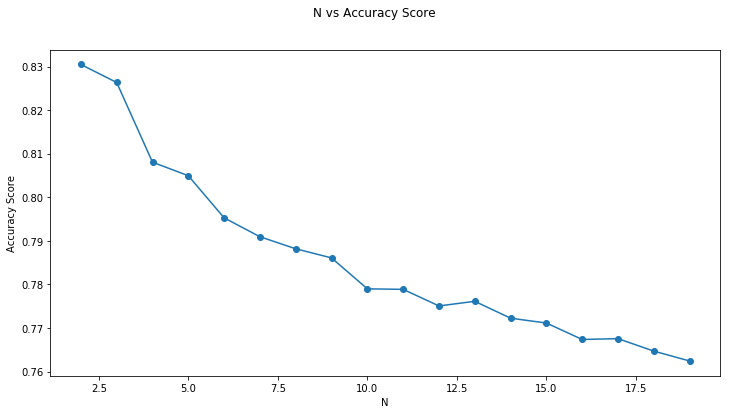

In [1021]:
plt.figure(figsize=(12,6))
plt.plot(rng,acc_scores,marker="o")
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.suptitle("N vs Accuracy Score")
plt.show()

In [993]:
modelName = "KNN5"
knn = KNeighborsClassifier(n_neighbors=2)
predictModelMetrics(knn,modelName)

Train Accuracy: 0.83
Cross Validation Accuracy: 0.71
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     8693                      322             650   
functional needs repair         894                      281             133   
non functional                 2444                      270            4133   
All                           12031                      873            4916   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [966]:
modelName = "RandomForestClassifier"
rfc = loadModel(modelName)
if(rfc == None):
    rfc = RandomForestClassifier(n_estimators=500,max_depth=15,random_state=rand_num)
    predictModelMetrics(rfc,modelName)
    saveModel(rfc,modelName)

In [968]:
modelName = "XGBoost_Classifier"
xgbc = loadModel(modelName)
if(xgbc == None):
    xgbc = XGBClassifier(max_depth=10,learning_rate= 0.01,n_estimators= 300,random_state=rand_num)
    predictModelMetrics(xgbc,modelName)
    saveModel(xgbc,modelName)

Train Accuracy: 0.79
Cross Validation Accuracy: 0.75
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     9017                       90             558   
functional needs repair         954                      195             159   
non functional                 2411                       61            4375   
All                           12382                      346            5092   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [969]:
test_preds = rfc.predict(test)

In [890]:
result = pd.DataFrame({'id':test_id,'status_group':test_preds})

In [892]:
result.to_csv("Submission.csv",index=False)